# 라이브러리 import

In [ ]:
# %% 표준 라이브러리
import os
import time
import random
from datetime import datetime, timedelta
# %% 수치·데이터 처리
import numpy as np
import pandas as pd
from collections import Counter

# %% 시각화
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter

# %% PyTorch 및 관련
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import StepLR, OneCycleLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from torch.amp import autocast


# %% torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import optuna

# %% 유틸리티
from torchinfo import summary
from tqdm import tqdm

# %% 데이터 분할
from sklearn.model_selection import StratifiedShuffleSplit

# %% 실험 추적
import wandb


plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우, 한글 지원 폰트로 설정
plt.rcParams['axes.unicode_minus'] = False       # 음수 기호가 깨지지 않도록 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import wandb
wandb.login()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

c:\Users\user1\anaconda3\envs\pt_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rmfth0438 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


device(type='cuda')

# 파라미터 정의

In [ ]:
DEBUG = False

if DEBUG:
    EPOCH = 2
    N_TRIALS = 2    
else:
    EPOCH = 20
    N_TRIALS = 20
    
BATCH_SIZE = 32
LR = 1e-4


IMAGE_SIZE = (224, 224)

DESEASE = 'MOSA'
model_version = f"EfficientNet_B0_{DESEASE}_TUNNING"
dataset = "SCALP"
model_type = model_version + '_' + datetime.now().strftime("%Y_%m_%d_%H")
    
data_path = rf'C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\data\mosa_org_preprocessV2'
save_model_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\model\{model_type}_model.pt"
save_history_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\history\{model_type}_history.pt"
save_result_csv_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\mosa_model_results.csv"

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

# 데이터 셋 정의

## transform 정의

In [4]:
# class CLAHETransform(object):
#     def __init__(self, clip_limit=0.4, grid_size=(4,4)):
#         self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)

#     def __call__(self, img):
#         img_np = np.array(img)
#         lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
#         l, a, b = cv2.split(lab)
#         l_clahe = self.clahe.apply(l)
#         lab_clahe = cv2.merge((l_clahe, a, b))
#         img_rgb = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
#         return Image.fromarray(img_rgb)

# # Sharpen transform
# class SharpenTransform(object):
#     def __call__(self, img):
#         return img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

# 3. 학습용 transform
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=4),
    transforms.Lambda(lambda x: x.rotate(90)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. 테스트/검증용 transform (반사광 제거, 대비 향상 동일하게 적용)
test_val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 커스텀 데이터 셋 정의

In [5]:
# ① 합친 클래스 이름 정의 (3개)
custom_order = ['양호', '경증', '중증']

class CustomOrderImageFolder(ImageFolder):
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 custom_order=None):
        self.custom_order = custom_order
        super().__init__(root, transform=transform, target_transform=target_transform)

    def find_classes(self, directory):
        if self.custom_order is not None:
            classes = self.custom_order
        else:
            classes = [d for d in os.listdir(directory)
                       if os.path.isdir(os.path.join(directory, d))]
            classes.sort()
        class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        return classes, class_to_idx

class CustomSubset(Dataset):
    def __init__(self, image_folder, indices, transform=None):
        self.image_folder = image_folder
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        path, label = self.image_folder.samples[actual_idx]
        image = self.image_folder.loader(path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# 전체 데이터셋 (test 폴더에서 전체 샘플 가져옴)
full_ds = CustomOrderImageFolder(
    root = os.path.join(data_path, 'test'),
    transform = None,                  # 무시되므로 None 으로
    custom_order = custom_order,
)

# Stratified Split (앞에서 설명된 대로)
labels = np.array([lbl for _, lbl in full_ds.samples])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

In [7]:
train_DS = CustomOrderImageFolder(
    root = os.path.join(data_path, 'train'),
    transform = train_transform,
    custom_order = custom_order,
)

val_DS = CustomSubset(
    image_folder=full_ds,
    indices=train_idx,
    transform=test_val_transform
)
test_DS = CustomSubset(
    image_folder=full_ds,
    indices=test_idx,
    transform=test_val_transform
)

if DEBUG:
    num_train = int(len(train_DS) * 0.1)
    num_val   = int(len(val_DS) * 0.1)
    train_DS  = Subset(train_DS, list(range(num_train)))
    val_DS    = Subset(val_DS,   list(range(num_val)))
    print(f"[DEBUG] train: {len(train_DS)}개, val: {len(val_DS)}개, test: {len(test_DS)}개")
    
else:
    # 1. train_DS의 라벨 추출
    if isinstance(train_DS, Subset):
        targets = [train_DS.dataset.samples[i][1] for i in train_DS.indices]
    else:
        targets = [lbl for _, lbl in train_DS.samples]

    # 2. StratifiedShuffleSplit을 활용해 50% 서브셋 인덱스 추출
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    subset_idx, _ = next(sss.split(np.zeros(len(targets)), targets))
    train_DS = Subset(train_DS, subset_idx)

    # val_DS도 50%로 축소 (val_DS는 CustomSubset이므로 targets 다르게 추출)
    if isinstance(val_DS, Subset):
        val_targets = [val_DS.dataset.samples[i][1] for i in val_DS.indices]
    else:
        val_targets = [full_ds.samples[i][1] for i in train_idx]
    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_subset_idx, _ = next(sss_val.split(np.zeros(len(val_targets)), val_targets))
    val_DS = Subset(val_DS, val_subset_idx)

    # test_DS도 50%로 축소
    if isinstance(test_DS, Subset):
        test_targets = [test_DS.dataset.samples[i][1] for i in test_DS.indices]
    else:
        test_targets = [full_ds.samples[i][1] for i in test_idx]
    sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    test_subset_idx, _ = next(sss_test.split(np.zeros(len(test_targets)), test_targets))
    test_DS = Subset(test_DS, test_subset_idx)

    print(f"[50% Subset] train: {len(train_DS)}개, val: {len(val_DS)}개, test: {len(test_DS)}개")

[50% Subset] train: 14436개, val: 2062개, test: 2062개


In [8]:
# train_DS의 모든 라벨 추출
if isinstance(train_DS, Subset):
    targets = [train_DS.dataset.samples[i][1] for i in train_DS.indices]
else:
    targets = [lbl for _, lbl in train_DS.samples]

# 클래스별 샘플 개수
class_sample_count = np.bincount(targets)
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
sample_weights = [weights[t] for t in targets]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [ ]:
train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=0, pin_memory=True, drop_last=True)
val_DL   = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
test_DL  = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

# Loss 정의

In [10]:
class DynamicFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=None, reduction='mean', num_classes=None):
        """
        alpha: 초기 클래스별 가중치 리스트 또는 Tensor. None이면 균등 분포로 초기화.
        gamma: focusing 파라미터
        reduction: 'none' | 'mean' | 'sum'
        num_classes: 클래스 수 (동적 기능 사용 시 반드시 지정)
        """
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

        if num_classes is None:
            raise ValueError("동적 가중치 기능을 사용하려면 num_classes를 지정해야 합니다.")
        self.num_classes = num_classes

        # α 초기화
        if alpha is not None:
            a = torch.tensor(alpha, dtype=torch.float)
            if a.numel() != num_classes:
                raise ValueError("alpha 길이와 num_classes 불일치")
            self.register_buffer('alpha', a)
        else:
            init_alpha = torch.ones(num_classes, dtype=torch.float) / num_classes
            self.register_buffer('alpha', init_alpha)

        # 통계 누적용 버퍼
        self.register_buffer('count', torch.zeros(num_classes, dtype=torch.long))
        self.register_buffer('errors', torch.zeros(num_classes, dtype=torch.long))

    def forward(self, inputs, targets):
        """
        inputs: (B, C) 로짓
        targets: (B,) 정수 레이블
        """
        # 1) cross-entropy 및 p_t 계산
        ce = F.cross_entropy(inputs, targets, reduction='none')  # [B]
        pt = torch.exp(-ce)                                      # [B]

        # 2) α 및 focal term
        at = self.alpha[targets]                                 # [B]
        focal_term = (1 - pt).pow(self.gamma)                    # [B]

        # 3) 최종 loss
        loss = at * focal_term * ce                              # [B]

        # 4) 통계 누적 (no grad)
        with torch.no_grad():
            # 클래스별 샘플 수
            one_hot = F.one_hot(targets, self.num_classes).long()  # (B, C)
            self.count += one_hot.sum(dim=0)

            # 예측
            preds = torch.argmax(inputs, dim=1)
            # 클래스별 오분류 수
            for cls in range(self.num_classes):
                mask = (targets == cls)
                if mask.any():
                    self.errors[cls] += (preds[mask] != cls).sum()

        # 5) reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

    @torch.no_grad()
    def update_alpha(self,
                     strategy: str = 'error',
                     min_alpha: float = 0.05,
                     max_alpha: float = 0.9):
        """
        strategy: 'frequency' 또는 'error'
        min_alpha, max_alpha: α를 이 범위 내로 클리핑
        """
        # 1) 새로운 α 계산
        if strategy == 'frequency':
            inv_freq = 1.0 / (self.count.float() + 1e-12)
            new_alpha = inv_freq / inv_freq.sum()
        elif strategy == 'error':
            err_rate = self.errors.float() / (self.count.float() + 1e-12)
            new_alpha = err_rate / err_rate.sum()
        else:
            raise ValueError(f"Unknown strategy: {strategy}")

        # 2) 클리핑: α가 너무 작거나 크지 않도록 제한
        new_alpha = new_alpha.clamp(min=min_alpha, max=max_alpha)

        # 3) 재정규화: 합이 1이 되도록
        new_alpha = new_alpha / new_alpha.sum()

        # 4) buffer에 복사 & 통계 초기화
        self.alpha.copy_(new_alpha)
        self.reset_stats()

    @torch.no_grad()
    def reset_stats(self):
        """count와 errors를 0으로 리셋"""
        self.count.zero_()
        self.errors.zero_()

In [11]:
if DEBUG:
    init_alpha = [0.1, 0.2, 0.3]
    num_classes = len(init_alpha)
else:
    # 1) train_DS에서 라벨만 추출 (Subset/원본 모두 대응)
    if isinstance(train_DS, Subset):
        labels = [train_DS.dataset.samples[i][1] for i in train_DS.indices]
        num_classes = len(train_DS.dataset.classes)
    else:
        labels = [label for _, label in train_DS.samples]
        num_classes = len(train_DS.classes)

    # 2) 클래스별 개수 세기
    counts = Counter(labels)
    total_samples = sum(counts.values())

    # 3) raw inverse-frequency 계산
    raw = np.array(
        [ total_samples / counts[i] for i in range(num_classes) ],
        dtype=np.float32
    )

    # 4) 정규화: 합이 1이 되도록
    init_alpha = (raw / raw.sum()).tolist()

    print("클래스별 개수:", [counts[i] for i in range(num_classes)])
    
print("초기화된 alpha:", init_alpha)

클래스별 개수: [267, 13041, 1128]
초기화된 alpha: [0.7954335808753967, 0.016285618767142296, 0.18828082084655762]


In [12]:
torch.cuda.empty_cache()

# 학습

In [14]:
def Train(
    model, train_DL, val_DL, criterion, optimizer,
    EPOCH, BATCH_SIZE,
    save_model_path, save_history_path,
    # ReduceLROnPlateau 하이퍼파라미터
    factor: float = 0.5,
    patience: int = 3,
    min_lr: float = 1e-5,
    # Early Stopping 하이퍼파라미터
    es_patience: int = 7,           # 개선 없을 때 몇 에폭 기다릴지
):
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min',
        factor=factor, patience=patience,
        min_lr=min_lr, verbose=True
    )
    
    loss_history = {'train': [], 'val': []}
    acc_history  = {
        'acc_train': [], 'acc_val': [],
        'recall2_train': [], 'recall2_val': []
    }
    best_loss = float('inf')
    epochs_no_improve = 0         # EarlyStopping 카운터

    for epoch in range(EPOCH):
        start = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}/{EPOCH}]  LR={current_lr:.2e}")

        # ── Train ──
        model.train()
        tr_loss, tr_acc, _, tr_recall2 = loss_epoch(
            model, train_DL, criterion,
            optimizer=optimizer, scheduler=None,
            scaler=scaler, recall_class=2
        )
        loss_history['train'].append(tr_loss)
        acc_history['acc_train'].append(tr_acc)
        acc_history['recall2_train'].append(tr_recall2)

        # ── Validation ──
        model.eval()
        with torch.no_grad():
            val_loss, val_acc, _, val_recall2 = loss_epoch(
                model, val_DL, criterion,
                optimizer=None, scheduler=None,
                scaler=None, recall_class=2
            )
        loss_history['val'].append(val_loss)
        acc_history['acc_val'].append(val_acc)
        acc_history['recall2_val'].append(val_recall2)

        # ReduceLROnPlateau
        scheduler.step(val_loss)

        # 모델 저장 및 EarlyStopping 체크
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save({
                'model': model.state_dict(),
                'epoch': epoch+1,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }, save_model_path)
            print("Model saved! (improved val_loss)")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{es_patience} epochs.")

        # 로그 출력
        elapsed = timedelta(seconds=round(time.time() - start))
        print(f"  train loss {tr_loss:.4f} acc {tr_acc:.1f}% recall2 {tr_recall2:.1f}%")
        print(f"    val loss {val_loss:.4f} acc {val_acc:.1f}% recall2 {val_recall2:.1f}%  time {elapsed}")
        print("-"*60)

        # W&B 기록
        wandb.log({
            'epoch': epoch + 1,
            'train/loss': tr_loss,
            'val/loss': val_loss,
            'train/acc': tr_acc,
            'val/acc': val_acc,
            'train/recall2': tr_recall2,
            'val/recall2': val_recall2,
            'learning_rate': current_lr
        })

        # 동적 α 업데이트
        if (epoch + 1) % 10 == 0:
            criterion.update_alpha(strategy='error', min_alpha=0.05, max_alpha=0.9)
            print("Updated alpha:", criterion.alpha.cpu().numpy())

        # ── Early Stopping 발동 조건 ──
        if epochs_no_improve >= es_patience:
            print(f"Early stopping: validation loss has not improved for {es_patience} epochs.")
            break

    # 히스토리 저장
    torch.save({
        "loss_history": loss_history,
        "acc_history" : acc_history,
        "EPOCH": epoch + 1,          # 실제 학습한 epoch 수
        "BATCH_SIZE": BATCH_SIZE,
    }, save_history_path)

    return loss_history, acc_history

def loss_epoch(model, DL, criterion, optimizer=None, scheduler=None,
               scaler=None, recall_class=2):
    """
    AMP: scaler가 주어지면 autocast()와 scaler를 사용해 mixed precision 학습
    """
    DEVICE = next(model.parameters()).device
    N = len(DL.dataset)
    total_loss = 0.0
    total_correct = 0
    true_pos = 0
    actual_pos = 0

    for x_batch, y_batch in tqdm(DL, leave=False):
        x = x_batch.to(DEVICE)
        y = y_batch.to(DEVICE)

        # forward + loss (AMP 적용)
        if scaler is not None:
            # 수정: torch.amp.autocast 사용, device_type 명시
            with autocast(device_type='cuda'):
                y_hat = model(x)
                raw = criterion(y_hat, y)
                loss = raw[0] if isinstance(raw, tuple) else raw
        else:
            y_hat = model(x)
            raw = criterion(y_hat, y)
            loss = raw[0] if isinstance(raw, tuple) else raw

        # backward & step
        if optimizer is not None:
            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            if scheduler is not None:
                scheduler.step()

        # accumulate loss & accuracy
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        preds = y_hat.argmax(dim=1)
        total_correct += (preds == y).sum().item()

        # recall 계산
        mask = (y == recall_class)
        actual_pos += mask.sum().item()
        true_pos   += ((preds == recall_class) & mask).sum().item()

    epoch_loss = total_loss / N
    epoch_acc  = total_correct / N * 100
    epoch_recall = (true_pos / actual_pos * 100) if actual_pos > 0 else 0.0

    return epoch_loss, epoch_acc, total_correct, epoch_recall

# 하이퍼 파라미터 튜닝 함수

In [ ]:
weight_decay_list = [1e-5, 1e-4, 1e-3]
focal_gamma_list = [1.0, 1.5, 2.0, 2.5]

In [ ]:
import itertools

results = []
trial_num = 0

for wd, fg in itertools.product(weight_decay_list, focal_gamma_list):
    print(f"\n--- Grid Search: trial {trial_num} | weight_decay={wd}, focal_gamma={fg} ---")

    wandb.init(
        project=f"Scalp_Disease_Classification_{DESEASE}_grid",
        name=f"trial_{trial_num}_wd{wd:.1e}_fg{fg:.2f}",
        config={"lr": LR, "weight_decay": wd, "focal_gamma": fg},
        reinit=True
    )
    
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.SiLU(),
        nn.Linear(512, 3)
    )
    model = model.to(DEVICE)
    
    criterion = DynamicFocalLoss(alpha=init_alpha, gamma=fg, reduction='mean', num_classes=3).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=wd)
    
    # train
    _, acc_history = Train(model, train_DL, val_DL, criterion, optimizer,
                           EPOCH, BATCH_SIZE, save_model_path, save_history_path)
    wandb.finish()
    val_acc = acc_history['acc_val'][-1]
    results.append({
        "trial": trial_num,
        "weight_decay": wd,
        "focal_gamma": fg,
        "val_acc": val_acc
    })
    trial_num += 1


In [ ]:
df_results = pd.DataFrame(results)
df_results.sort_values(by='val_acc', ascending=False)

In [ ]:
best_row = df_results.loc[df_results['val_acc'].idxmax()]
best_weight_decay = best_row['weight_decay']
best_focal_gamma  = best_row['focal_gamma']

# 재학습

In [17]:
# 0. 데이터 다시 불러오기
# 전체 데이터셋 (test 폴더에서 전체 샘플 가져옴)
full_ds = CustomOrderImageFolder(
    root = os.path.join(data_path, 'test'),
    transform = None,                  # 무시되므로 None 으로
    custom_order = custom_order,
)

# Stratified Split (앞에서 설명된 대로)
labels = np.array([lbl for _, lbl in full_ds.samples])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

train_DS = CustomOrderImageFolder(
    root = os.path.join(data_path, 'train'),
    transform = train_transform,
    custom_order = custom_order,
)

val_DS = CustomSubset(
    image_folder=full_ds,
    indices=train_idx,
    transform=test_val_transform
)
test_DS = CustomSubset(
    image_folder=full_ds,
    indices=test_idx,
    transform=test_val_transform
)

# train_DS의 모든 라벨 추출
if isinstance(train_DS, Subset):
    targets = [train_DS.dataset.samples[i][1] for i in train_DS.indices]
else:
    targets = [lbl for _, lbl in train_DS.samples]

# 클래스별 샘플 개수
class_sample_count = np.bincount(targets)
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
sample_weights = [weights[t] for t in targets]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=0, pin_memory=True)
val_DL   = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_DL  = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
final_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = final_model.classifier[1].in_features
final_model.classifier[1] = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.SiLU(),
    nn.Linear(512, 3)
)
final_model = final_model.to(DEVICE)

final_criterion = DynamicFocalLoss(
    alpha=init_alpha,
    gamma=best_focal_gamma,
    reduction='mean',
    num_classes=3
).to(DEVICE)

final_optimizer = torch.optim.Adam(
    final_model.parameters(), lr=LR, weight_decay=best_weight_decay
)

In [ ]:
# 3. wandb로 최종 학습 기록 시작 (실험명 구분)
wandb.init(
    project=f"Scalp_Disease_Classification_{DESEASE}",
    name=f"FINAL_MODEL_{DESEASE}",
    config={
        "lr": LR,
        "weight_decay": best_weight_decay,
        "focal_gamma": best_focal_gamma,
        "epochs": 50
    }
)

In [21]:
# 4. 전체 epoch(예: 50) 재학습
EPOCH = 50  # 또는 원하는 epoch 수
save_model_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\model\{model_type}_final_model.pt"
save_history_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\history\{model_type}_final_history.pt"

final_loss_history, final_acc_history = Train(
    final_model, train_DL, val_DL, final_criterion, final_optimizer,
    EPOCH, BATCH_SIZE, save_model_path, save_history_path)

C:\Users\user1\AppData\Local\Temp\ipykernel_8068\3905160355.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\user1\anaconda3\envs\pt_py311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 1/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0322 acc 66.8% recall2 88.3%
    val loss 0.0192 acc 18.8% recall2 89.8%  time 0:03:13
------------------------------------------------------------
[Epoch 2/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0109 acc 70.7% recall2 97.5%
    val loss 0.0178 acc 24.2% recall2 94.4%  time 0:03:14
------------------------------------------------------------
[Epoch 3/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0081 acc 74.9% recall2 98.5%
    val loss 0.0155 acc 32.8% recall2 96.0%  time 0:03:13
------------------------------------------------------------
[Epoch 4/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0067 acc 78.0% recall2 98.8%
    val loss 0.0135 acc 41.1% recall2 95.7%  time 0:03:13
------------------------------------------------------------
[Epoch 5/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0057 acc 80.5% recall2 99.1%
    val loss 0.0120 acc 46.4% recall2 96.6%  time 0:03:12
------------------------------------------------------------
[Epoch 6/50]  LR=1.00e-05


No improvement for 1/7 epochs.
  train loss 0.0050 acc 83.1% recall2 99.2%
    val loss 0.0124 acc 49.2% recall2 92.9%  time 0:03:12
------------------------------------------------------------
[Epoch 7/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0045 acc 84.4% recall2 99.3%
    val loss 0.0094 acc 58.6% recall2 95.3%  time 0:03:13
------------------------------------------------------------
[Epoch 8/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0041 acc 85.8% recall2 99.3%
    val loss 0.0083 acc 65.1% recall2 91.6%  time 0:03:12
------------------------------------------------------------
[Epoch 9/50]  LR=1.00e-05


No improvement for 1/7 epochs.
  train loss 0.0039 acc 86.9% recall2 99.4%
    val loss 0.0091 acc 62.6% recall2 93.5%  time 0:03:12
------------------------------------------------------------
[Epoch 10/50]  LR=1.00e-05


Model saved! (improved val_loss)
  train loss 0.0034 acc 88.1% recall2 99.6%
    val loss 0.0082 acc 67.2% recall2 92.5%  time 0:03:11
------------------------------------------------------------
Updated alpha: [0.05 0.9  0.05]
[Epoch 11/50]  LR=1.00e-05


No improvement for 1/7 epochs.
  train loss 0.0227 acc 82.9% recall2 58.0%
    val loss 0.0377 acc 93.0% recall2 43.8%  time 0:03:11
------------------------------------------------------------
[Epoch 12/50]  LR=1.00e-05


No improvement for 2/7 epochs.
  train loss 0.0157 acc 81.6% recall2 53.6%
    val loss 0.0273 acc 93.4% recall2 43.2%  time 0:03:12
------------------------------------------------------------
[Epoch 13/50]  LR=1.00e-05


No improvement for 3/7 epochs.
  train loss 0.0137 acc 82.3% recall2 53.5%
    val loss 0.0336 acc 93.3% recall2 46.6%  time 0:03:11
------------------------------------------------------------
[Epoch 14/50]  LR=1.00e-05


No improvement for 4/7 epochs.
  train loss 0.0127 acc 83.2% recall2 55.7%
    val loss 0.0250 acc 93.3% recall2 38.8%  time 0:03:11
------------------------------------------------------------
[Epoch 15/50]  LR=1.00e-05


No improvement for 5/7 epochs.
  train loss 0.0117 acc 84.7% recall2 60.1%
    val loss 0.0311 acc 93.2% recall2 50.0%  time 0:03:11
------------------------------------------------------------
[Epoch 16/50]  LR=1.00e-05


No improvement for 6/7 epochs.
  train loss 0.0105 acc 85.9% recall2 64.0%
    val loss 0.0268 acc 93.0% recall2 42.9%  time 0:03:11
------------------------------------------------------------
[Epoch 17/50]  LR=1.00e-05


No improvement for 7/7 epochs.
  train loss 0.0094 acc 87.1% recall2 65.9%
    val loss 0.0240 acc 93.1% recall2 39.1%  time 0:03:12
------------------------------------------------------------
Early stopping: validation loss has not improved for 7 epochs.


# 결과 시각화

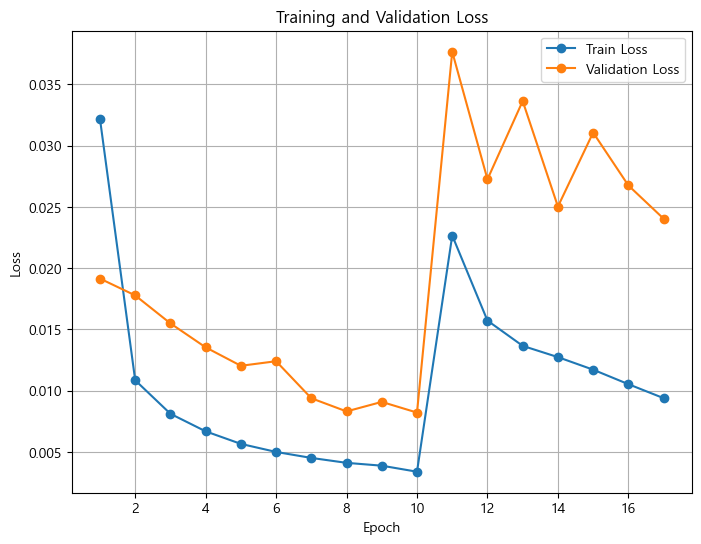

In [22]:
checkpoint = torch.load(save_history_path, map_location=DEVICE)

plt.figure(figsize=(8,6))
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['loss_history']['train'], label='Train Loss', marker='o')
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['loss_history']['val'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

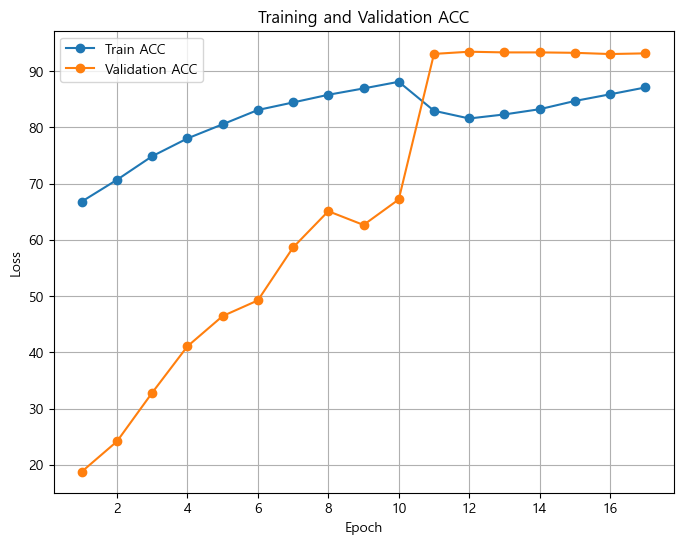

In [23]:
plt.figure(figsize=(8,6))
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['acc_history']['acc_train'], label='Train ACC', marker='o')
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['acc_history']['acc_val'], label='Validation ACC', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation ACC')
plt.legend()
plt.grid()
plt.show()

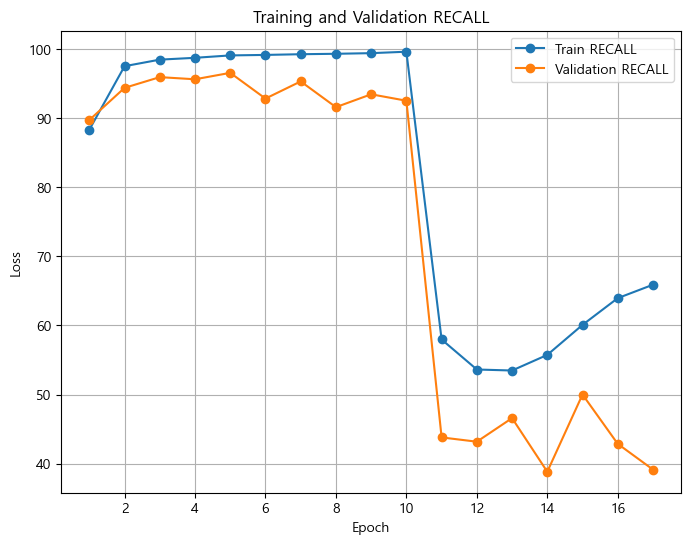

In [24]:
plt.figure(figsize=(8,6))
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['acc_history']['recall2_train'], label='Train RECALL', marker='o')
plt.plot(range(1, checkpoint['EPOCH'] + 1), checkpoint['acc_history']['recall2_val'], label='Validation RECALL', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation RECALL')
plt.legend()
plt.grid()
plt.show()

# 테스트

In [25]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

def Test(model, test_DL, criterion, num_classes, recall_class=2):
    """
    모델을 평가하고, 손실/정확도/리콜 지표와
    클래스별 정확도, classification report,
    그리고 실제 vs 예측 레이블을 반환합니다.
    """
    model.eval()
    DEVICE = next(model.parameters()).device

    total_loss   = 0.0
    total_correct= 0
    true_pos     = 0
    actual_pos   = 0
    all_preds    = []
    all_labels   = []

    class_correct = [0] * num_classes
    class_total   = [0] * num_classes

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_DL, desc="Testing"):
            x = x_batch.to(DEVICE)
            y = y_batch.to(DEVICE)

            # 순전파 + 손실 계산
            y_hat = model(x)
            raw   = criterion(y_hat, y)
            loss  = raw if not isinstance(raw, (tuple,list)) else raw[0]

            batch_size = x.size(0)
            total_loss    += loss.item() * batch_size
            preds         = y_hat.argmax(dim=1)
            total_correct += (preds == y).sum().item()

            # 클래스별 correct/total 집계
            for label, pred in zip(y.cpu().tolist(), preds.cpu().tolist()):
                class_total[label]   += 1
                if pred == label:
                    class_correct[label] += 1

            # 특정 클래스(recall_class) 리콜 집계
            mask         = (y == recall_class)
            actual_pos  += mask.sum().item()
            true_pos    += ((preds == recall_class) & mask).sum().item()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    N = len(test_DL.dataset)
    test_loss   = total_loss / N
    test_acc    = total_correct / N * 100
    test_recall = (true_pos / actual_pos * 100) if actual_pos > 0 else 0.0

    # 클래스별 정확도 계산 (%)
    class_accs = [
        (class_correct[i] / class_total[i] * 100) if class_total[i] > 0 else 0.0
        for i in range(num_classes)
    ]

    # classification report 생성
    report_dict = classification_report(
        all_labels, all_preds,
        output_dict=True, digits=4
    )

    return test_loss, test_acc, test_recall, class_accs, report_dict, all_labels, all_preds


In [ ]:
model = efficientnet_b0()  # 사용자 정의 모델 클래스
in_features = model.classifier[1].in_features  # 보통 1792
model.classifier[1] = nn.Sequential(nn.Linear(in_features, 512),
                                    nn.BatchNorm1d(512),       # 배치 정규화 추가
                                    nn.ReLU(),                 # 혹은 nn.ReLU()
                                    nn.Linear(512, 3))         # 최종 클래스 수
model.load_state_dict(torch.load(save_model_path, weights_only=False)['model'])

model.to(DEVICE)

test_loss, test_acc, test_recall, class_accs, report_dict, all_labels, all_preds = Test(model, test_DL, final_criterion, num_classes, recall_class=2)

# 2) 매크로 평균 정밀도·F1 추출
macro = report_dict['macro avg']
precision = macro['precision'] * 100
f1_score  = macro['f1-score'] * 100

# 3) 깔끔한 출력
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_acc:.1f}%")
print(f"Recall(2): {test_recall:.1f}%")
print(f"Precision (macro): {precision:.2f}%")
print(f"F1 Score   (macro): {f1_score:.2f}%")

Testing: 100%|██████████| 129/129 [00:18<00:00,  6.93it/s]

Loss:      0.2827
Accuracy:  71.8%
Recall(2): 92.9%
Precision (macro): 47.44%
F1 Score   (macro): 50.38%


In [27]:
f1_macro = report_dict['macro avg']['f1-score'] * 100  # % 단위로 변환

# 저장할 딕셔너리 구성
data = {
    "Model": [model_type],
    "Recall":[test_recall],
    "F1":    [f1_macro],           # Macro F1 추가
    "ACC":   [test_acc],
}

# 클래스별 ACC 컬럼 추가
class_names = ["양호", "경증", "중증"]
for i, acc in enumerate(class_accs):
    data[f"ACC_{class_names[i]}"] = [acc]

# DataFrame 생성 및 CSV에 append/저장
df = pd.DataFrame(data)

df = df.round(2)

if os.path.isfile(save_result_csv_path):
    df.to_csv(save_result_csv_path, mode="a", header=False, index=False)
else:
    df.to_csv(save_result_csv_path, index=False)

# 결과 확인
df = pd.read_csv(save_result_csv_path)
df = df.round(2)
df

,Model,Recall,F1,ACC,ACC_양호,ACC_경증,ACC_중증
0,EfficientNet_B4_BIDDEM_V1.1_2025_05_19_12,64.21,40.12,45.20,100.00,29.92,64.21
1,EfficientNet_B4_BIDDEM_V1.1_2025_05_19_14,64.21,40.12,45.20,100.00,29.92,64.21
2,EfficientNet_B4_BIDDEM_V1.1_2025_05_19_14,64.21,40.12,45.20,100.00,29.92,64.21
3,EfficientNet_B3_BIDDEM_V1_2025_05_19_16,100.00,19.31,40.79,0.00,0.00,100.00
4,EfficientNet_B3_BIDDEM_V1.1_2025_05_19_17,100.00,19.31,40.79,0.00,0.00,100.00
5,EfficientNet_B3_BIDDEM_V1.1_2025_05_20_15,100.00,19.31,40.79,0.00,0.00,100.00
6,EfficientNet_B3_BIDDEM_V1.1_2025_05_20_15,100.00,19.31,40.79,0.00,0.00,100.00
7,EfficientNet_B3_BIDDEM_V1.1_2025_05_20_15,79.55,60.11,72.62,92.11,67.08,79.55
8,EfficientNet_B3_BIDDEM_V1.2_2025_05_20_22,49.41,63.39,73.64,82.89,90.57,49.41
9,EfficientNet_B3_BIDDEM_V3.1_2025_05_24_19,90.99,55.21,77.64,93.42,76.17,90.99


In [28]:
# ── 혼동 행렬 계산 및 정규화 ──
cm      = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

# DataFrame으로 보기 좋게 정리
index   = [f"True_{i}" for i in range(num_classes)]
columns = [f"Pred_{i}" for i in range(num_classes)]
df_cm   = pd.DataFrame(cm_norm, index=index, columns=columns)
df_cm = df_cm.round(2)
print("\n=== Normalized Confusion Matrix (rows sum to 1) ===")
print(df_cm)


=== Normalized Confusion Matrix (rows sum to 1) ===
        Pred_0  Pred_1  Pred_2
True_0    0.87    0.13    0.00
True_1    0.09    0.70    0.21
True_2    0.01    0.07    0.93


In [ ]:
import gc
import torch

# 모델 객체 삭제 (필요한 경우 이름 확인 후)
try:
    del model
except:
    pass

gc.collect()

try:
    torch.cuda.empty_cache()
except:
    pass